# Основная часть

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
DATASET_PATH = 'mnist_data'

In [3]:
class NoiseTransform(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        if random.random() <= self.p:
            noise_factor = 0.4
            noisy_image = image + noise_factor * np.random.normal(
                loc=0.0, scale=1.0, size=image.shape
            )

            return np.clip(noisy_image, 0.0, 1.0).astype(np.float32)
        else:
            return image

In [4]:
transform = transforms.Compose([NoiseTransform(p=0.75),transforms.ToTensor()])

In [5]:
def visualize_images(data, n_rows, n_cols):
    n_samples = n_rows * n_cols

    if len(data) != n_samples:
        sample_indices = np.random.choice(len(data), n_samples, replace=len(data) < n_samples)
    else:
        sample_indices = np.arange(len(data)).astype(int)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(data[sample_index][0], cmap='gray')
        plt.axis("off")
    plt.show()

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, train=True, transform=transforms.ToTensor(), label_transform=transforms.ToTensor()):
        # list of tuples: (img_path, label)
        self._data = MNIST(DATASET_PATH, train=train, download=True)
        # for augmentation
        self._transform = transform
        self._label_transform = label_transform

    def __len__(self):
        return len(self._data)

    def __getitem__(self, index):
        img, label = self._data[index]

        img_noisy = self._transform(img)
        img = self._label_transform(img)

        return img_noisy, img

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc_conv1 = nn.Conv2d(1, 32, 3, padding=(1,1))
        self.enc_pool1 = nn.MaxPool2d(2, 2)
        self.enc_conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.enc_pool2 = nn.MaxPool2d(2, 2)
        # Decoder
        self.dec_tconv1 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1)
        self.dec_tconv2 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1)
        self.dec_conv1 = nn.Conv2d(32, 1, 3, padding=(1,1))
    def forward(self, x):
        # Encoder
        x = self.enc_pool1(F.relu(self.enc_conv1(x)))
        x = self.enc_pool2(F.relu(self.enc_conv2(x)))
        
        # Decoder
        x = F.relu(self.dec_tconv1(x))
        x = F.relu(self.dec_tconv2(x))
        print(x[0])
        
        x = torch.sigmoid(self.dec_conv1(x))
        return x

In [8]:
class AutoEncoderModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.autoencoder = AutoEncoder()

        self.loss = nn.BCELoss()

    def forward(self, x):
        x = self.autoencoder(x)
        return x

    def training_step(self, batch, batch_idx):
        noisy_img, img = batch

        denoised_img = self(noisy_img)
        loss = self.loss(denoised_img, img)

        return {'loss': loss}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=5e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  mode='min',
                                                                  factor=0.2,
                                                                  patience=5,
                                                                  verbose=True)
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_loss"
        }

        return [optimizer], [lr_dict]

    def validation_step(self, batch, batch_idx):
        noisy_img, img = batch

        denoised_img = self(noisy_img)
        loss = self.loss(denoised_img, img)

        return {'val_loss': loss}

    def training_epoch_end(self, outputs):
        """log and display average train loss across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()

        print(f"| Train_loss: {avg_loss:.5f}")

        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)

    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()

        print(f"[Epoch {self.trainer.current_epoch:3}] Val_loss: {avg_loss:.5f}", end=" ")

        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)

In [9]:
train_dataset = MNISTDataset(train=True, transform=transform)
val_dataset = MNISTDataset(train=False, transform=transform)

In [10]:
train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

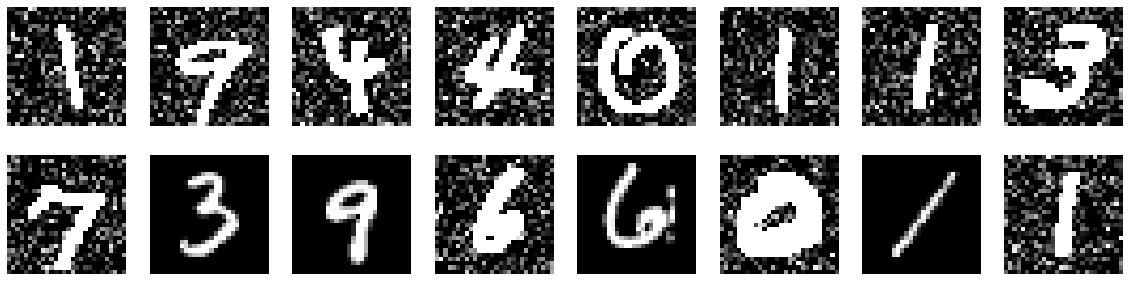

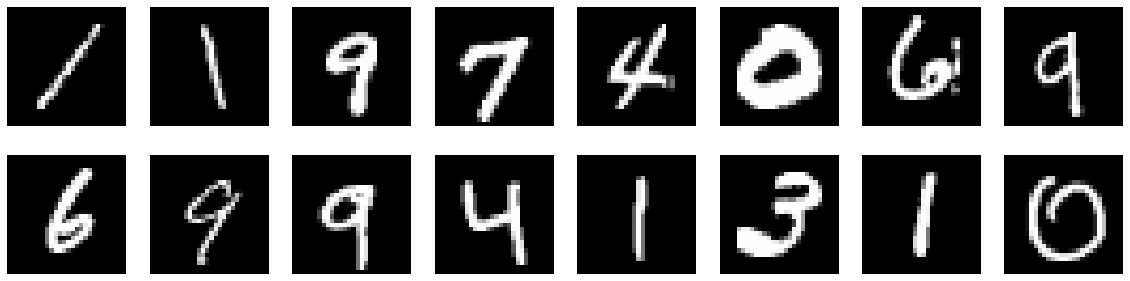

In [11]:
sample_batch = next(iter(train_dl))
visualize_images(sample_batch[0], 2, 8)
visualize_images(sample_batch[1], 2, 8)

In [12]:
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_encoder',
                                        filename='{epoch}-{val_loss:.3f}',
                                        monitor='val_loss',
                                        mode='min',
                                        save_top_k=3)

## Monitor a metric and stop training when it stops improving.
#MyEarlyStopping = EarlyStopping(monitor="val_loss", mode="min", patience=4, verbose=True)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    callbacks=[
        #MyEarlyStopping, 
        MyModelCheckpoint
    ],
    log_every_n_steps=5
)

model = AutoEncoderModule()
#model.cuda()

trainer.fit(model, train_dl, val_dl)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name        | Type        | Params
--------------------------------------------
0 | autoencoder | AutoEncoder | 28.4 K
1 | loss        | BCELoss     | 0     
--------------------------------------------
28.4 K    Trainable params
0         Non-trainable params
28.4 K    Total params
0.113     Total estimated model params size (MB)
/home/v.pyatov/anaconda3/envs/ImgReg/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory /home/v.pyatov/cuda_prac/autoencoder/runs/pl_encoder exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.69417 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.08342 | Train_loss: 0.10423


Validating: 0it [00:00, ?it/s]

[Epoch   1] Val_loss: 0.08126 | Train_loss: 0.08342


Validating: 0it [00:00, ?it/s]

[Epoch   2] Val_loss: 0.08137 | Train_loss: 0.08225


Validating: 0it [00:00, ?it/s]

[Epoch   3] Val_loss: 0.08015 | Train_loss: 0.08167


Validating: 0it [00:00, ?it/s]

[Epoch   4] Val_loss: 0.08134 | Train_loss: 0.08135


Validating: 0it [00:00, ?it/s]

[Epoch   5] Val_loss: 0.08026 | Train_loss: 0.08112


Validating: 0it [00:00, ?it/s]

[Epoch   6] Val_loss: 0.07999 | Train_loss: 0.08106


Validating: 0it [00:00, ?it/s]

[Epoch   7] Val_loss: 0.08101 | Train_loss: 0.08083


Validating: 0it [00:00, ?it/s]

[Epoch   8] Val_loss: 0.07994 | Train_loss: 0.08078


Validating: 0it [00:00, ?it/s]

[Epoch   9] Val_loss: 0.08173 | Train_loss: 0.08067


Validating: 0it [00:00, ?it/s]

[Epoch  10] Val_loss: 0.08059 | Train_loss: 0.08058


Validating: 0it [00:00, ?it/s]

[Epoch  11] Val_loss: 0.07942 | Train_loss: 0.08058


Validating: 0it [00:00, ?it/s]

[Epoch  12] Val_loss: 0.07953 | Train_loss: 0.08051


Validating: 0it [00:00, ?it/s]

[Epoch  13] Val_loss: 0.07968 | Train_loss: 0.08044


Validating: 0it [00:00, ?it/s]

[Epoch  14] Val_loss: 0.07997 | Train_loss: 0.08052


Validating: 0it [00:00, ?it/s]

[Epoch  15] Val_loss: 0.07942 | Train_loss: 0.08043


Validating: 0it [00:00, ?it/s]

[Epoch  16] Val_loss: 0.07958 | Train_loss: 0.08046


Validating: 0it [00:00, ?it/s]

[Epoch  17] Val_loss: 0.07974 | Train_loss: 0.08040
Epoch    18: reducing learning rate of group 0 to 2.0000e-04.


Validating: 0it [00:00, ?it/s]

[Epoch  18] Val_loss: 0.07910 | Train_loss: 0.07962


Validating: 0it [00:00, ?it/s]

[Epoch  19] Val_loss: 0.07891 | Train_loss: 0.07956


Validating: 0it [00:00, ?it/s]

[Epoch  20] Val_loss: 0.07874 | Train_loss: 0.07951


Validating: 0it [00:00, ?it/s]

[Epoch  21] Val_loss: 0.07890 | Train_loss: 0.07953


Validating: 0it [00:00, ?it/s]

[Epoch  22] Val_loss: 0.07929 | Train_loss: 0.07950


Validating: 0it [00:00, ?it/s]

[Epoch  23] Val_loss: 0.07893 | Train_loss: 0.07946


Validating: 0it [00:00, ?it/s]

[Epoch  24] Val_loss: 0.07901 | Train_loss: 0.07951


Validating: 0it [00:00, ?it/s]

[Epoch  25] Val_loss: 0.07878 | Train_loss: 0.07951


Validating: 0it [00:00, ?it/s]

[Epoch  26] Val_loss: 0.07865 | Train_loss: 0.07949


Validating: 0it [00:00, ?it/s]

[Epoch  27] Val_loss: 0.07869 | Train_loss: 0.07948


Validating: 0it [00:00, ?it/s]

[Epoch  28] Val_loss: 0.07878 | Train_loss: 0.07951


Validating: 0it [00:00, ?it/s]

[Epoch  29] Val_loss: 0.07869 | Train_loss: 0.07942


Validating: 0it [00:00, ?it/s]

[Epoch  30] Val_loss: 0.07866 | Train_loss: 0.07940


Validating: 0it [00:00, ?it/s]

[Epoch  31] Val_loss: 0.07878 | Train_loss: 0.07943


Validating: 0it [00:00, ?it/s]

[Epoch  32] Val_loss: 0.07875 | Train_loss: 0.07942
Epoch    33: reducing learning rate of group 0 to 4.0000e-05.


Validating: 0it [00:00, ?it/s]

[Epoch  33] Val_loss: 0.07854 | Train_loss: 0.07915


Validating: 0it [00:00, ?it/s]

[Epoch  34] Val_loss: 0.07853 | Train_loss: 0.07920


Validating: 0it [00:00, ?it/s]

[Epoch  35] Val_loss: 0.07874 | Train_loss: 0.07922


Validating: 0it [00:00, ?it/s]

[Epoch  36] Val_loss: 0.07862 | Train_loss: 0.07916


Validating: 0it [00:00, ?it/s]

[Epoch  37] Val_loss: 0.07865 | Train_loss: 0.07920


Validating: 0it [00:00, ?it/s]

[Epoch  38] Val_loss: 0.07871 | Train_loss: 0.07916


Validating: 0it [00:00, ?it/s]

[Epoch  39] Val_loss: 0.07861 | Train_loss: 0.07921


Validating: 0it [00:00, ?it/s]

[Epoch  40] Val_loss: 0.07860 | Train_loss: 0.07918
Epoch    41: reducing learning rate of group 0 to 8.0000e-06.


Validating: 0it [00:00, ?it/s]

[Epoch  41] Val_loss: 0.07844 | Train_loss: 0.07914


Validating: 0it [00:00, ?it/s]

[Epoch  42] Val_loss: 0.07846 | Train_loss: 0.07910


Validating: 0it [00:00, ?it/s]

[Epoch  43] Val_loss: 0.07867 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  44] Val_loss: 0.07859 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  45] Val_loss: 0.07872 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  46] Val_loss: 0.07859 | Train_loss: 0.07916


Validating: 0it [00:00, ?it/s]

[Epoch  47] Val_loss: 0.07841 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  48] Val_loss: 0.07850 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  49] Val_loss: 0.07847 | Train_loss: 0.07913


Validating: 0it [00:00, ?it/s]

[Epoch  50] Val_loss: 0.07845 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  51] Val_loss: 0.07848 | Train_loss: 0.07905


Validating: 0it [00:00, ?it/s]

[Epoch  52] Val_loss: 0.07862 | Train_loss: 0.07916


Validating: 0it [00:00, ?it/s]

[Epoch  53] Val_loss: 0.07867 | Train_loss: 0.07915
Epoch    54: reducing learning rate of group 0 to 1.6000e-06.


Validating: 0it [00:00, ?it/s]

[Epoch  54] Val_loss: 0.07856 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  55] Val_loss: 0.07847 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  56] Val_loss: 0.07838 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  57] Val_loss: 0.07853 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  58] Val_loss: 0.07849 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  59] Val_loss: 0.07854 | Train_loss: 0.07913


Validating: 0it [00:00, ?it/s]

[Epoch  60] Val_loss: 0.07845 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  61] Val_loss: 0.07854 | Train_loss: 0.07915


Validating: 0it [00:00, ?it/s]

[Epoch  62] Val_loss: 0.07859 | Train_loss: 0.07908
Epoch    63: reducing learning rate of group 0 to 3.2000e-07.


Validating: 0it [00:00, ?it/s]

[Epoch  63] Val_loss: 0.07846 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  64] Val_loss: 0.07842 | Train_loss: 0.07914


Validating: 0it [00:00, ?it/s]

[Epoch  65] Val_loss: 0.07830 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  66] Val_loss: 0.07850 | Train_loss: 0.07913


Validating: 0it [00:00, ?it/s]

[Epoch  67] Val_loss: 0.07844 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  68] Val_loss: 0.07854 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  69] Val_loss: 0.07841 | Train_loss: 0.07903


Validating: 0it [00:00, ?it/s]

[Epoch  70] Val_loss: 0.07843 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  71] Val_loss: 0.07845 | Train_loss: 0.07912
Epoch    72: reducing learning rate of group 0 to 6.4000e-08.


Validating: 0it [00:00, ?it/s]

[Epoch  72] Val_loss: 0.07851 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  73] Val_loss: 0.07859 | Train_loss: 0.07910


Validating: 0it [00:00, ?it/s]

[Epoch  74] Val_loss: 0.07846 | Train_loss: 0.07910


Validating: 0it [00:00, ?it/s]

[Epoch  75] Val_loss: 0.07843 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  76] Val_loss: 0.07850 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  77] Val_loss: 0.07838 | Train_loss: 0.07909
Epoch    78: reducing learning rate of group 0 to 1.2800e-08.


Validating: 0it [00:00, ?it/s]

[Epoch  78] Val_loss: 0.07860 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  79] Val_loss: 0.07855 | Train_loss: 0.07906


Validating: 0it [00:00, ?it/s]

[Epoch  80] Val_loss: 0.07849 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  81] Val_loss: 0.07862 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  82] Val_loss: 0.07849 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  83] Val_loss: 0.07855 | Train_loss: 0.07906
Epoch    84: reducing learning rate of group 0 to 2.5600e-09.


Validating: 0it [00:00, ?it/s]

[Epoch  84] Val_loss: 0.07858 | Train_loss: 0.07906


Validating: 0it [00:00, ?it/s]

[Epoch  85] Val_loss: 0.07847 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  86] Val_loss: 0.07850 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  87] Val_loss: 0.07851 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  88] Val_loss: 0.07856 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  89] Val_loss: 0.07854 | Train_loss: 0.07911


Validating: 0it [00:00, ?it/s]

[Epoch  90] Val_loss: 0.07855 | Train_loss: 0.07906


Validating: 0it [00:00, ?it/s]

[Epoch  91] Val_loss: 0.07849 | Train_loss: 0.07909


Validating: 0it [00:00, ?it/s]

[Epoch  92] Val_loss: 0.07844 | Train_loss: 0.07912


Validating: 0it [00:00, ?it/s]

[Epoch  93] Val_loss: 0.07843 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  94] Val_loss: 0.07852 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  95] Val_loss: 0.07857 | Train_loss: 0.07914


Validating: 0it [00:00, ?it/s]

[Epoch  96] Val_loss: 0.07851 | Train_loss: 0.07910


Validating: 0it [00:00, ?it/s]

[Epoch  97] Val_loss: 0.07848 | Train_loss: 0.07908


Validating: 0it [00:00, ?it/s]

[Epoch  98] Val_loss: 0.07846 | Train_loss: 0.07907


Validating: 0it [00:00, ?it/s]

[Epoch  99] Val_loss: 0.07849 | Train_loss: 0.07907


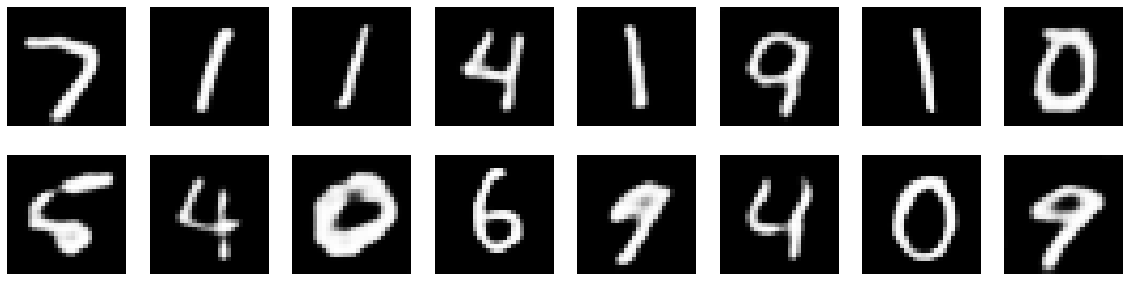

In [13]:
sample_batch = next(iter(val_dl))
visualize_images(model(sample_batch[0]).detach(), 2, 8)

In [22]:
from array import array

def save_model_weights(model, output_path):
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    for param_name, weight in model.named_parameters():
        param_name = param_name.replace('.', '_') + '.bin'
        param_path = os.path.join(output_path, param_name)
        output_file = open(param_path, 'wb')
        float_array = array('f', weight.detach().cpu().numpy().reshape(-1))
        float_array.tofile(output_file)
        output_file.close()

In [23]:
save_model_weights(model.autoencoder, 'autoencoder_weights')

# Дополнительная часть

Во всех экспериментах для каждого из разрешений (28, 64, 128, 256, 512) запускался бенчмарк с параметром запуска 100. Расчитывалось total time (т.е суммарное время всех выделений памяти, расчетов, освобождений) и operation time (время операций слоев нейросети, без учета копирования, выделения и освобожения)
Ниже визуализация полученый результатов. (Также добавил бенчмарк обычной модели, без улучшений - на графике это simple_model)

### Слияние слоев

Активации ReLU и Sigmoid выполняются в сверточном ядре. На графике это fused_model

### Разделяемая память
В shared_layers.cu реализованы слои свертки-активации с использованием shared memory. В Shared функциях в разделяемую память загружаются веса (это есть на графике - shared_model). SharedFeature функции загружают в разделяемую память FeatureMap (этот вариант прироста не дал)

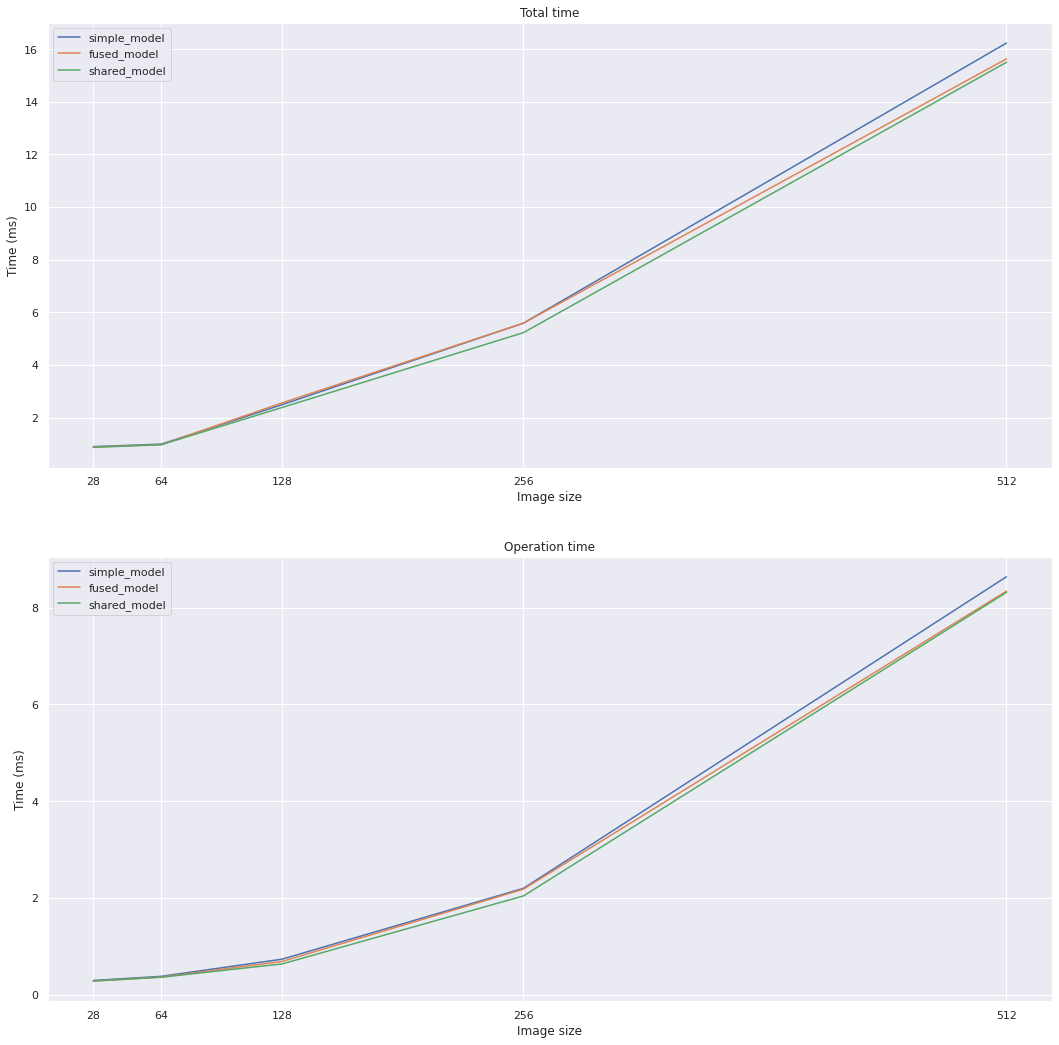

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
%matplotlib inline

fig, axes = plt.subplots(2, 1, figsize=(18, 18))

sizes = [28, 64, 128, 256, 512]

simple_model_total = [0.894155, 0.987708, 2.48738, 5.58785, 16.2363]
fused_model_total = [0.880459, 0.966792, 2.55531, 5.58738, 15.634]
shared_model_total = [0.864773, 0.965681, 2.38004, 5.22703, 15.5041]

simple_model_op = [0.294918, 0.379467, 0.733857, 2.19882, 8.63827]
fused_model_op = [0.283229, 0.364435, 0.687092, 2.18177, 8.34091]
shared_model_op = [0.281386, 0.361141, 0.635644, 2.04165, 8.31571]

sns.lineplot(ax=axes[0], x=sizes, y=simple_model_total, label='simple_model')
sns.lineplot(ax=axes[0], x=sizes, y=fused_model_total, label='fused_model')
sns.lineplot(ax=axes[0], x=sizes, y=shared_model_total, label='shared_model')
axes[0].set_xticks(sizes)
axes[0].set_title('Total time')
axes[0].set_ylabel('Time (ms)')
axes[0].set_xlabel('Image size')

sns.lineplot(ax=axes[1], x=sizes, y=simple_model_op, label='simple_model')
sns.lineplot(ax=axes[1], x=sizes, y=fused_model_op, label='fused_model')
sns.lineplot(ax=axes[1], x=sizes, y=shared_model_op, label='shared_model')
axes[1].set_xticks(sizes)
axes[1].set_title('Operation time')
axes[1].set_ylabel('Time (ms)')
axes[1].set_xlabel('Image size')
plt.show()

### Оптимизации

* Оказалось, если не выностить операции выделения и копирования памяти в начало (и потом просто последовательно выполнить кернелы), а расположить их перед вызовами функций в которых эта память используется, то для разрешения 512х512 получаем выигрыш в 0.83 ms!!! Мне кажется, так быть не должно, потому что операции выделения и копирования сихронизируются в основном потоке. По крайней мере написано, что они синхронные... Может какие-то оптимизации включились, магия... Заметил это в начале работы, поэтому подробного бенчмарка для каждого разрешения не сохранилось

* Я решил распределить вычисления по стримам. На то есть две причины. Во-первых, когда делается паддинг, можно параллельно копировать веса на девайс в другом стриме, чтобы после паддинга сразу выполнить свертку (а не ждать копирования весов). Во-вторых, в декодировщике нужно поменять местами первые два канала у тензора весов (потому что для транспонированой сверки они храняться в формате C_in x C_out x H x W, а для обычной в формате C_out x C_in x H x W) и перевернуть матрицу в каждом канале – это тоже можно сделать в отдельном стриме. Для этого эксперимента я убрал таймеры с операций и измерял только total время, но уже по 1000 проходам. График представлен ниже - это streams_model. Получилось супер:)

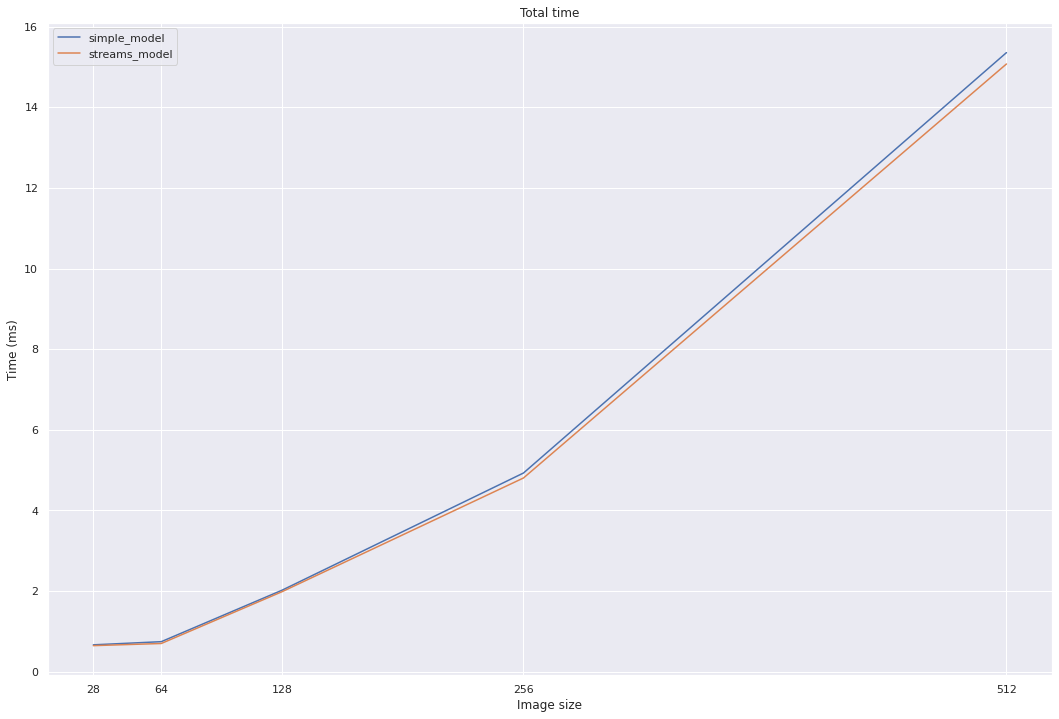

In [38]:
fig = plt.figure(figsize=(18, 12))

sizes = [28, 64, 128, 256, 512]

simple_model = [0.664524, 0.742641, 2.01906, 4.92705, 15.3557]
streams_model = [0.644046,0.697516,1.98221, 4.80363, 15.0742]

sns.lineplot(x=sizes, y=simple_model, label='simple_model')
sns.lineplot(x=sizes, y=streams_model, label='streams_model')
plt.xticks(sizes)
plt.title('Total time')
plt.ylabel('Time (ms)')
plt.xlabel('Image size')
plt.show()